# Data Visualization Analyisis

## Data Loading

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import UserDefinedFunction, col, mean, log1p, UserDefinedFunction, explode, rand, when, lit, count
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.sql.types import FloatType
import os

"""
Spark session variables declaration and spark initialization
"""

path = os.getcwd()

conf = SparkConf() \
    .setAppName("PostgreSQL Writing to Formatted Table") \
    .set("spark.jars", path+"/../.."+"/driver/postgresql-42.7.3.jar")

spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()


"""
Connection details for table from formatted zone read
"""

jdbc_url = "jdbc:postgresql://localhost:5432/bda_project1_db"
driver_class = "org.postgresql.Driver"
user = "postgres"
password = "hola123"
connectionProperties = {"user": "postgres", "password": "hola123"}


df_caract = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bda_project1_db") \
    .option("dbtable", "dog_caract_trusted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df_caract = df_caract.withColumnRenamed("Breed", "breed")

df_caract.show()

24/04/25 13:57:28 WARN Utils: Your hostname, marcel-compu resolves to a loopback address: 127.0.1.1; using 10.192.244.123 instead (on interface wlp3s0)
24/04/25 13:57:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/04/25 13:57:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/25 13:57:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|               breed|playfulness|protectiveness|shedding|trainability|avg_height_female|avg_height_male|avg_life_expectancy|avg_weight_male_log_normalized|avg_weight_female_log_normalized|
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+
|      1|          1|       0|     0|                 3|                   3|                  0|       0|    Ameri

In [2]:
df_intel = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://localhost:5432/bda_project1_db") \
    .option("dbtable", "dog_intelligence_trusted") \
    .option("user", connectionProperties["user"]) \
    .option("password", connectionProperties["password"]) \
    .option("driver", "org.postgresql.Driver") \
    .load()

df_intel.show()

+--------------------+--------------------+----+--------+
|               breed|      classification|obey|avg_reps|
+--------------------+--------------------+----+--------+
|       Border Collie|      Brightest Dogs|  95|     2.5|
|              Poodle|      Brightest Dogs|  95|     2.5|
|     German Shepherd|      Brightest Dogs|  95|     2.5|
|    Golden Retriever|      Brightest Dogs|  95|     2.5|
|   Doberman Pinscher|      Brightest Dogs|  95|     2.5|
|   Shetland Sheepdog|      Brightest Dogs|  95|     2.5|
|  Labrador Retriever|      Brightest Dogs|  95|     2.5|
|            Papillon|      Brightest Dogs|  95|     2.5|
|          Rottweiler|      Brightest Dogs|  95|     2.5|
|Australian Cattle...|      Brightest Dogs|  95|     2.5|
|Pembroke Welsh Corgi|Excellent Working...|  85|    10.0|
| Miniature Schnauzer|Excellent Working...|  85|    10.0|
|English Springer ...|Excellent Working...|  85|    10.0|
|Belgian Shepherd ...|Excellent Working...|  85|    10.0|
|          Sch

## Table Join

In [3]:
df = df_caract.join(df_intel, 
               df_caract.breed == df_intel.breed, 
               "inner").drop(df_intel.breed) # Drop allows to remove duplicates
df = df.distinct()
print(df.count())
df.show()

112
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+--------------------+----+--------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|               breed|playfulness|protectiveness|shedding|trainability|avg_height_female|avg_height_male|avg_life_expectancy|avg_weight_male_log_normalized|avg_weight_female_log_normalized|      classification|obey|avg_reps|
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+--------------------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+--------------------+----+--------+
|     

# Univariant Analysis

In [4]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Numerical Variables Visualization

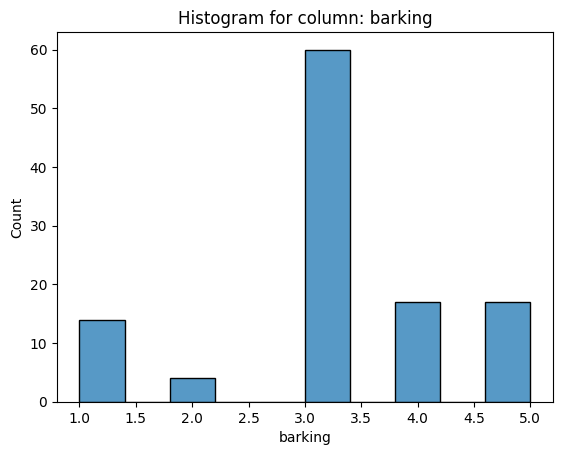

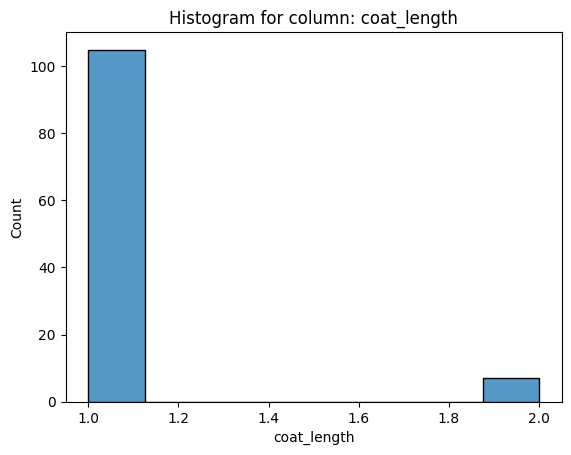

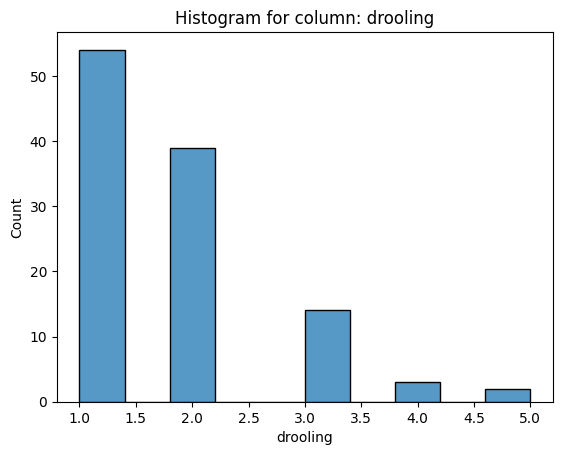

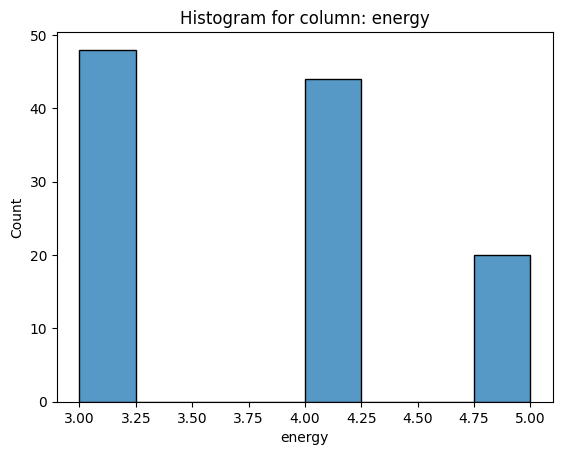

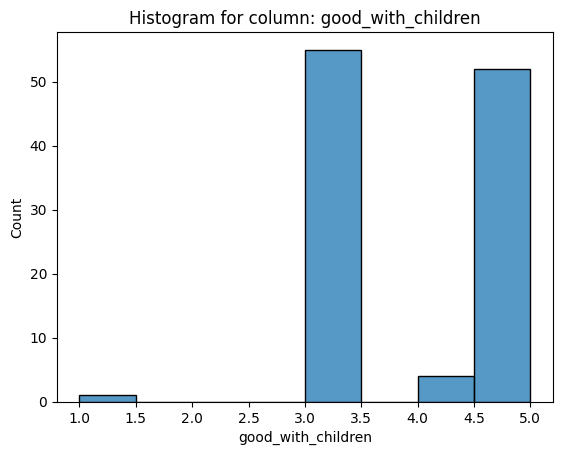

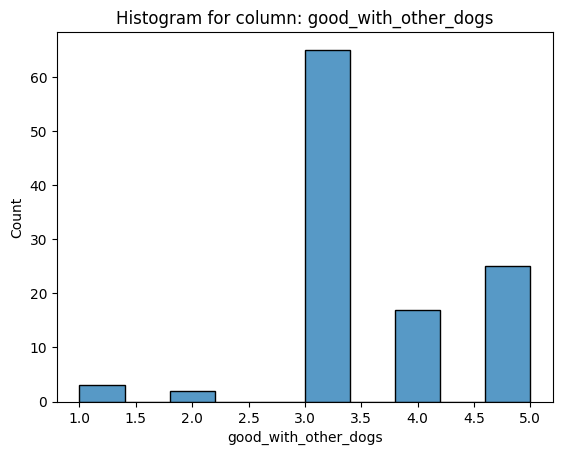

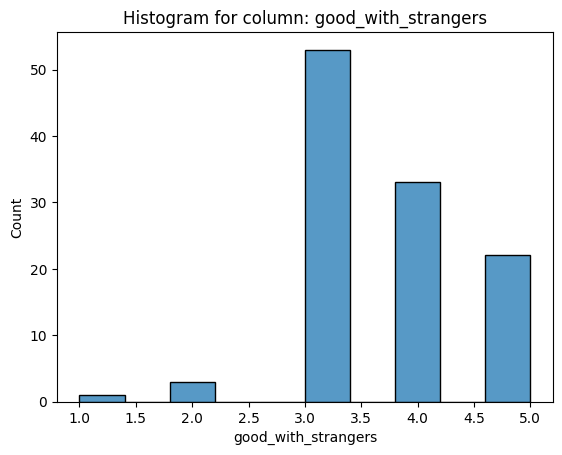

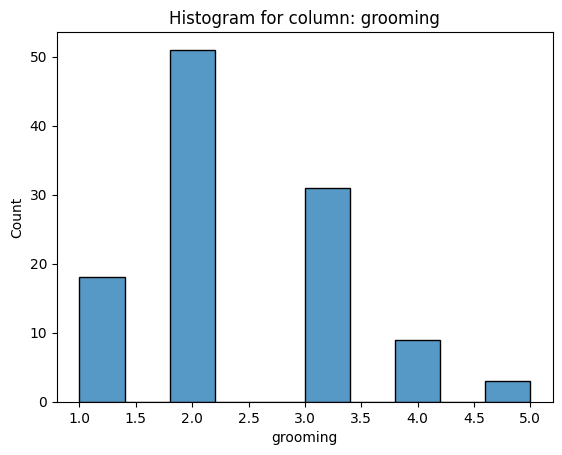

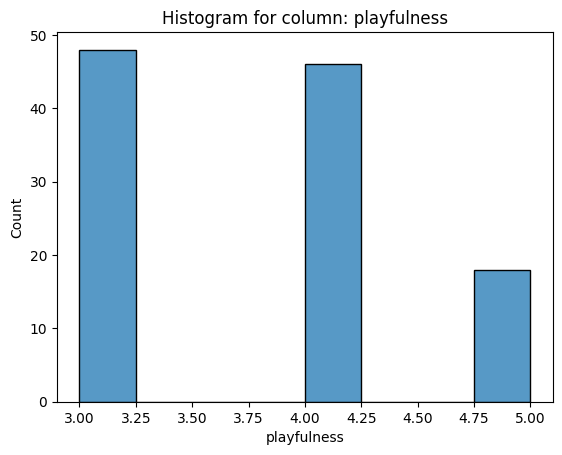

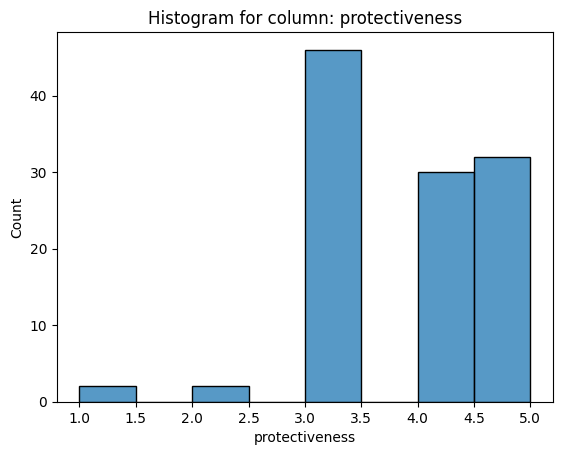

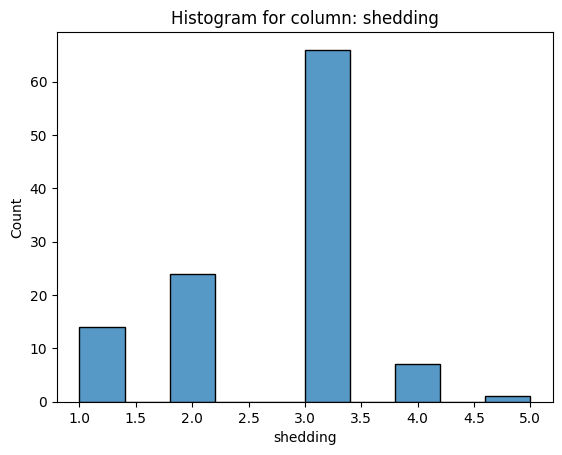

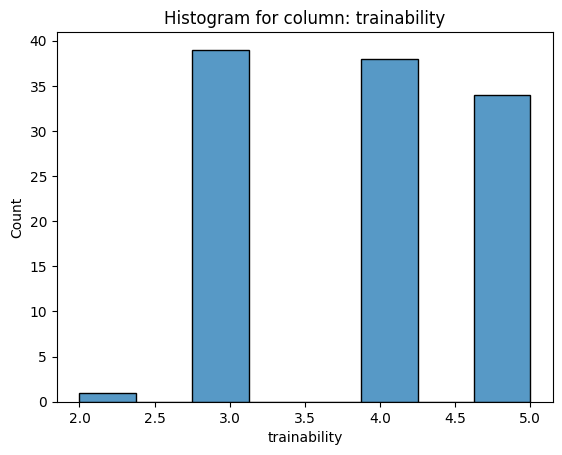

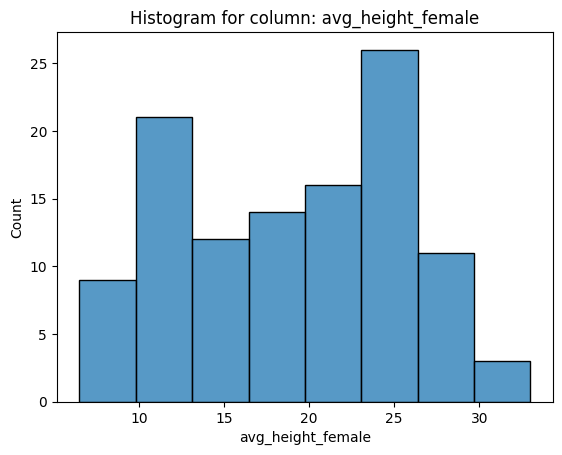

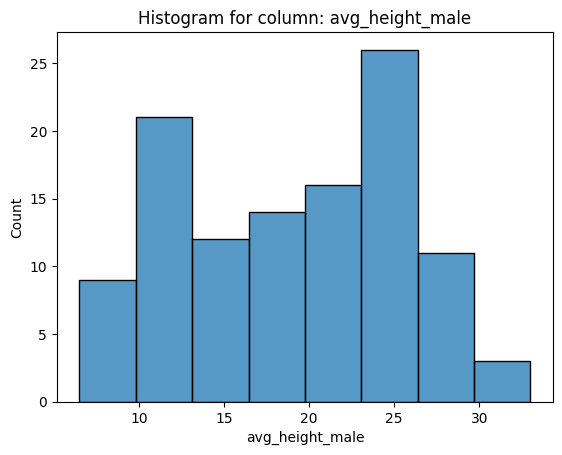

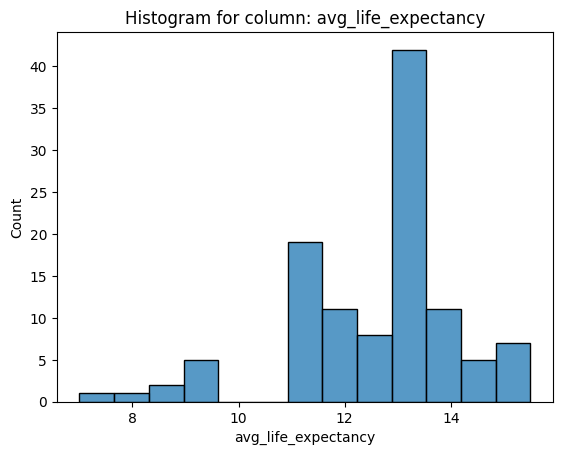

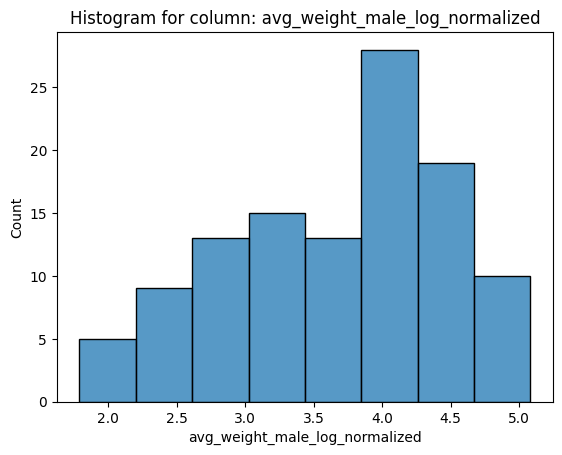

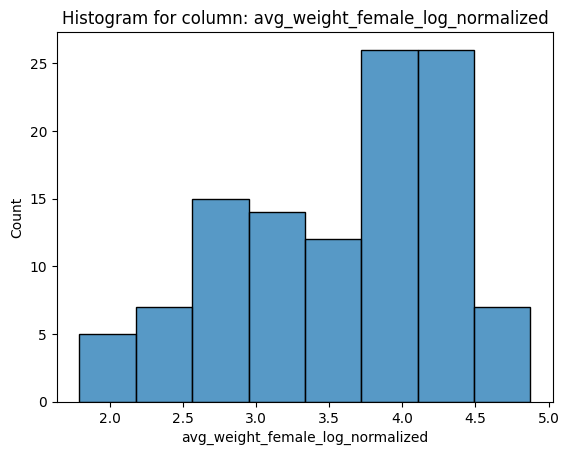

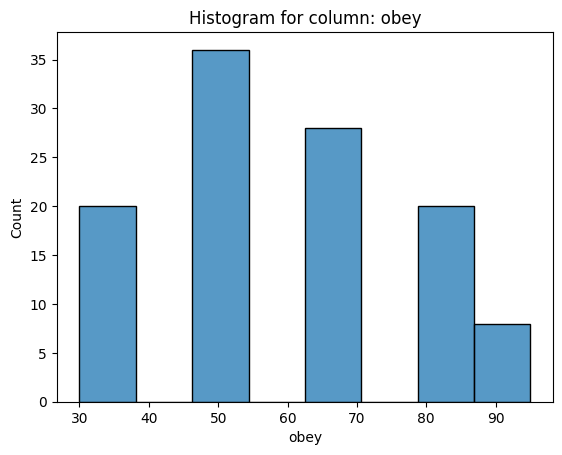

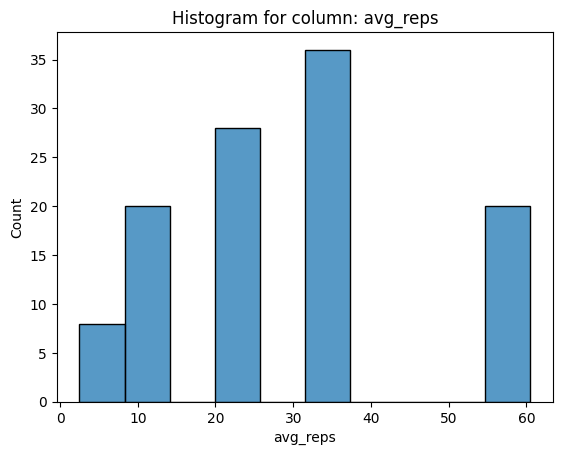

In [5]:
numeric_variables = [column for column, dtype in df.dtypes if dtype == "int" or dtype == "double" or dtype == "bigint"]
for num_col in numeric_variables:
  df_pandas = df.toPandas()
  sns.histplot(data=df_pandas, x=num_col)
  plt.title(f"Histogram for column: {num_col}")
  plt.show()

## Categorical Variables Visualization

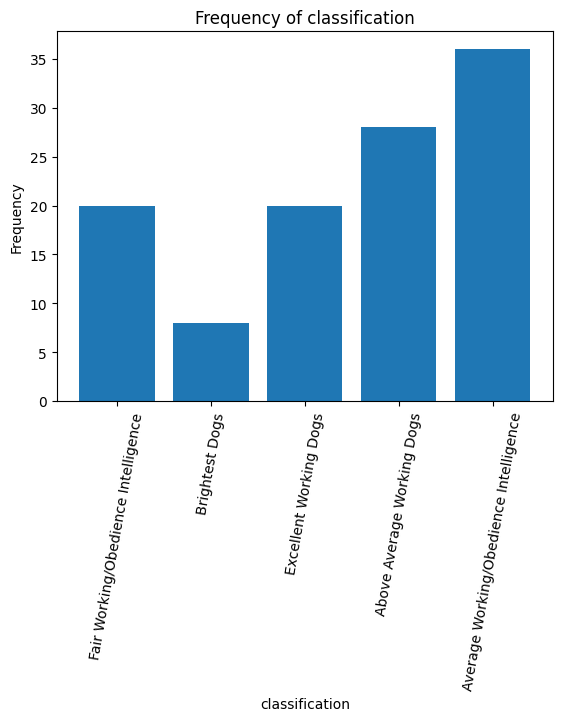

In [6]:
df_pandas = df.toPandas()

selected_column = "classification"

frequency_counts = df.groupBy(selected_column).agg(count(col(selected_column)).alias("count"))

frequency_counts_pandas = frequency_counts.toPandas()

plt.xticks(rotation=80)
plt.bar(frequency_counts_pandas[selected_column], frequency_counts_pandas["count"])
plt.xlabel(selected_column)
plt.ylabel("Frequency")
plt.title(f"Frequency of {selected_column}")
plt.show()


# Bivariant Analysis

# Multivariant Analysis

## Clustering

In [7]:
from pyspark.ml.clustering import KMeans 
from pyspark.ml.evaluation import ClusteringEvaluator 

### Data preparation

In [8]:
# Dummy cols...
pivoted = df.groupBy("breed").pivot("classification").agg(lit(1))
pivoted = pivoted.na.fill(0)
df = df.join(pivoted, 
               df.breed == pivoted.breed, 
               "inner").drop(pivoted.breed) # Drop allows to remove duplicates
df = df.distinct()
print(df.count())
df.show()

24/04/25 13:57:44 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


112
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+--------------------+----+--------+--------------------+--------------------------+--------------------------------------+--------------+----------------------+-----------------------------------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|playfulness|protectiveness|shedding|trainability|avg_height_female|avg_height_male|avg_life_expectancy|avg_weight_male_log_normalized|avg_weight_female_log_normalized|      classification|obey|avg_reps|               breed|Above Average Working Dogs|Average Working/Obedience Intelligence|Brightest Dogs|Excellent Working Dogs|Fair Working/Obedience Intelligence|
+-------+-----------+--------+------+------------------+

In [9]:
df = df.drop('breed') # It does not make sense as there is one breed per row
df = df.drop('classification') # It does not make sense as we have it encoded now
df.show()

+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+-----------+--------------+--------+------------+-----------------+---------------+-------------------+------------------------------+--------------------------------+----+--------+--------------------------+--------------------------------------+--------------+----------------------+-----------------------------------+
|barking|coat_length|drooling|energy|good_with_children|good_with_other_dogs|good_with_strangers|grooming|playfulness|protectiveness|shedding|trainability|avg_height_female|avg_height_male|avg_life_expectancy|avg_weight_male_log_normalized|avg_weight_female_log_normalized|obey|avg_reps|Above Average Working Dogs|Average Working/Obedience Intelligence|Brightest Dogs|Excellent Working Dogs|Fair Working/Obedience Intelligence|
+-------+-----------+--------+------+------------------+--------------------+-------------------+--------+-----------+--------------+--------+--

In [13]:
df.columns

['barking',
 'coat_length',
 'drooling',
 'energy',
 'good_with_children',
 'good_with_other_dogs',
 'good_with_strangers',
 'grooming',
 'playfulness',
 'protectiveness',
 'shedding',
 'trainability',
 'avg_height_female',
 'avg_height_male',
 'avg_life_expectancy',
 'avg_weight_male_log_normalized',
 'avg_weight_female_log_normalized',
 'obey',
 'avg_reps',
 'Above Average Working Dogs',
 'Average Working/Obedience Intelligence',
 'Brightest Dogs',
 'Excellent Working Dogs',
 'Fair Working/Obedience Intelligence']

In [14]:
assembler = VectorAssembler(inputCols=df.columns, outputCol="features")
data_df = assembler.transform(df)

# Scaling the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)

In [ ]:
vec_assembler = VectorAssembler(inputCols = df.columns, 
                                outputCol='features') 
  
df = vec_assembler.transform(df) 
df.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[3.0,2.0,1.0,3.0,...|
|[3.0,2.0,1.0,3.0,...|
|[2.0,1.0,1.0,4.0,...|
|[3.0,1.0,1.0,4.0,...|
|[5.0,1.0,1.0,4.0,...|
+--------------------+
only showing top 5 rows



In [ ]:
scaler = StandardScaler(inputCol="features",  
                        outputCol="scaledFeatures",  
                        withStd=True,  
                        withMean=False) 
  
# Compute summary statistics by fitting the StandardScaler 
scalerModel = scaler.fit(df) 
  
# Normalize each feature to have unit standard deviation. 
df_clustering = scalerModel.transform(df) 
  
df_clustering.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|[2.65448442255625...|
|[2.65448442255625...|
|[1.76965628170416...|
|[2.65448442255625...|
|[4.42414070426042...|
+--------------------+
only showing top 5 rows



In [ ]:
null_counts = df_clustering.select(col("scaledFeatures").isNull().alias("isNull")).groupBy("isNull").count()
null_counts.show()

+------+-----+
|isNull|count|
+------+-----+
| false|  112|
+------+-----+



In [ ]:
silhouette_score=[] 
  
evaluator = ClusteringEvaluator(predictionCol='prediction', 
                                featuresCol='scaledFeatures', 
                                metricName='silhouette',  
                                distanceMeasure='squaredEuclidean') 

  
for i in range(2,10): 
    kmeans=KMeans(featuresCol='scaledFeatures', k=i) 
    model=kmeans.fit(df_clustering) 
    predictions=model.transform(df_clustering)
    score=evaluator.evaluate(predictions) 
    silhouette_score.append(score) 
    print('Silhouette Score for k =',i,'is',score)

24/04/25 13:52:34 WARN BlockManager: Putting block rdd_2483_0 failed due to exception java.lang.NullPointerException.
24/04/25 13:52:34 WARN BlockManager: Block rdd_2483_0 could not be removed as it was not found on disk or in memory
24/04/25 13:52:34 ERROR Executor: Exception in task 0.0 in stage 1197.0 (TID 660)
java.lang.NullPointerException
24/04/25 13:52:34 WARN TaskSetManager: Lost task 0.0 in stage 1197.0 (TID 660) (10-192-244-123client.eduroam.upc.edu executor driver): java.lang.NullPointerException

24/04/25 13:52:34 ERROR TaskSetManager: Task 0 in stage 1197.0 failed 1 times; aborting job
24/04/25 13:52:34 ERROR Instrumentation: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1197.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1197.0 (TID 660) (10-192-244-123client.eduroam.upc.edu executor driver): java.lang.NullPointerException

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGSche

Py4JJavaError: An error occurred while calling o4931.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 1197.0 failed 1 times, most recent failure: Lost task 0.0 in stage 1197.0 (TID 660) (10-192-244-123client.eduroam.upc.edu executor driver): java.lang.NullPointerException

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1296)
	at org.apache.spark.rdd.RDD.$anonfun$takeSample$1(RDD.scala:629)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.takeSample(RDD.scala:618)
	at org.apache.spark.mllib.clustering.KMeans.initKMeansParallel(KMeans.scala:400)
	at org.apache.spark.mllib.clustering.KMeans.runAlgorithmWithWeight(KMeans.scala:273)
	at org.apache.spark.mllib.clustering.KMeans.runWithWeight(KMeans.scala:231)
	at org.apache.spark.ml.clustering.KMeans.trainWithRow(KMeans.scala:446)
	at org.apache.spark.ml.clustering.KMeans.$anonfun$fit$1(KMeans.scala:382)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:371)
	at org.apache.spark.ml.clustering.KMeans.fit(KMeans.scala:295)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.NullPointerException
